# ETL Pipelines

In [1]:
import os
import sqlite3
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import firebase_admin
from openai import OpenAI
import plotly.express as px
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pycountry import countries
from firebase_admin import storage
from IPython.display import display
pd.options.mode.copy_on_write = True
from firebase_admin import credentials
from datetime import datetime,timedelta
from sklearn.preprocessing import StandardScaler

## 1. Data Ingestion

### 1.1 Extract Similar Types of Data

In [2]:
# Import Similar Types of Data from CSV File
df1 = pd.read_csv('../data_source/mystery.csv', encoding='utf-16')
df2 = pd.read_csv('../data_source/gdp_data.csv', skiprows=4)
df3 = pd.read_csv('../data_source/electricity_access_percent.csv', skiprows=4)
df4 = pd.read_csv('../data_source/rural_population_percent.csv', skiprows=4)

### 1.2 Extract Population Data

In [3]:
# Import Population Data from CSV File
p1 = pd.read_csv('../data_source/population_data.csv', skiprows=4)

In [4]:
# Import Population Data from Database
conn = sqlite3.connect("../data_source/population_data.db")
p2 = pd.read_sql("SELECT * FROM population_data", conn)
conn.close()

In [5]:
# Import Population Data from XML
with open('../data_source/population_data.xml') as file:    
    soup = BeautifulSoup(file, 'lxml')
    
data = []
for record in soup.find_all('record'):
    record_data = {}
    
    for field in record.find_all('field'):
        if field['name'] != "Item":
            name = field['name']
            value = field.text
            record_data[name] = value
            if field['name'] == "Country or Area":
                country_code = field['key']
                record_data['Country Code'] = country_code
            

    data.append(record_data)

p3 = pd.DataFrame(data)

In [6]:
# Import Population Data from JSON
p4 = pd.read_json('../data_source/population_data.json')

### 1.3 Extract Projects Data

In [7]:
# Import Projects Data from CSV File
proj = pd.read_csv('../data_source/projects_data.csv', low_memory=False)

### 1.4 Extract Data from API

In [8]:
api_pop = pd.read_csv("../data_source/api_population_data.csv")
api_gdp = pd.read_csv("../data_source/api_gdp_data.csv")
api_elec = pd.read_csv("../data_source/api_electricity_access_data.csv")
api_rural = pd.read_csv("../data_source/api_rural_population_data.csv")

In [9]:
dfs = [api_pop, api_gdp, api_rural, api_elec]

for df in dfs:
    print(df.shape)
    display(df.head())

(266, 8)


,Country Name,Country Code,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,NaN
1,Africa Eastern and Southern,AFE,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,NaN
2,Africa Western and Central,AFW,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,NaN
3,Albania,ALB,2866376.0,2854191.0,2837849.0,2811666.0,2777689.0,NaN
4,Algeria,DZA,41927007.0,42705368.0,43451666.0,44177969.0,44903225.0,NaN


(266, 8)


,Country Name,Country Code,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,1.805322e+10,1.879944e+10,1.995593e+10,1.426650e+10,NaN,NaN
1,Africa Eastern and Southern,AFE,1.012521e+12,1.006191e+12,9.288802e+11,1.086531e+12,1.185138e+12,NaN
2,Africa Western and Central,AFW,7.681582e+11,8.234056e+11,7.869624e+11,8.449275e+11,8.753937e+11,NaN
3,Albania,ALB,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.891638e+10,NaN
4,Algeria,DZA,1.749107e+11,1.717603e+11,1.457435e+11,1.634724e+11,1.949984e+11,NaN


(266, 8)


,Country Name,Country Code,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,74.505000,74.246000,73.974000,73.686000,73.384000,NaN
1,Africa Eastern and Southern,AFE,64.152402,63.663741,63.171698,62.676301,62.174842,NaN
2,Africa Western and Central,AFW,53.350574,52.744587,52.142169,51.545194,50.952615,NaN
3,Albania,ALB,39.681000,38.771000,37.888000,37.031000,36.201000,NaN
4,Algeria,DZA,27.371000,26.811000,26.267000,25.739000,25.228000,NaN


(266, 8)


,Country Name,Country Code,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,93.430878,97.700000,97.700000,97.700000,NaN,NaN
1,Africa Eastern and Southern,AFE,43.028332,44.389773,46.268621,48.103609,NaN,NaN
2,Africa Western and Central,AFW,51.212863,51.160817,51.734388,54.224187,NaN,NaN
3,Albania,ALB,100.000000,100.000000,100.000000,100.000000,NaN,NaN
4,Algeria,DZA,99.637741,99.500000,99.718773,99.787827,NaN,NaN


In [10]:
proj = pd.read_csv('../data_source/projects_data.csv', low_memory=False)

## 2. Data Cleansing and Transformation

### 2.1 Define Functions

In [11]:
# Function to Clean Columns
def clean_columns(df):
    columns_to_remove = ['index','Unnamed', 'Indicator Name', 'Indicator Code']
    return df.loc[:, ~df.columns.str.contains('|'.join(columns_to_remove))]

In [12]:
# Function to Melt dataframes
def perform_melt(df, value_name):
    return pd.melt(df, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name=value_name)

In [13]:
# Function to Fill missing values
def fill_missing_values(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_columns] = df[numeric_columns].bfill(axis=1).ffill(axis=1)
    df.fillna(0, inplace=True)
    return df

In [14]:
def fill_missing_values_elec(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_columns] = df[numeric_columns].ffill(axis=1)
    df.fillna(0, inplace=True)
    return df

In [15]:
# Function Convert Datetime to Year
def convert_year(df):
    df['Year'] = pd.to_datetime(df['Year']).dt.year
    return df

### 2.2 Process Similar Types of Data

In [16]:
[print(df['Country Name'].duplicated().sum()) for df in [df1, df2, df3, df4]]


0
0
0
0


[None, None, None, None]

In [17]:
# Clean Columns
data_frames = [df1, df2, df3, df4]
for i, df in enumerate(data_frames):
    data_frames[i] = clean_columns(df)
df1, df2, df3, df4 = data_frames

In [18]:
data_frames = [api_pop, api_gdp, api_elec, api_rural]

for i, df in enumerate(data_frames):
    data_frames[i]["Country Name"] = df["Country Name"].replace({"Viet Nam": "Vietnam"}, regex=True)

api_pop, api_gdp, api_elec, api_rural = data_frames

In [19]:
api_pop.shape

(266, 8)

In [20]:
# List of DataFrames and their corresponding API data
dfs = [df1, df2, df3, df4]
apis = [api_pop, api_gdp, api_elec, api_rural]

# Merge each DataFrame with its corresponding API data
for i in range(len(dfs)):
    dfs[i] = dfs[i].merge(apis[i], on=['Country Name', 'Country Code'])

df1, df2, df3, df4 = dfs

In [21]:
df1

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,103795.0,104341.0,104822.0,105264.0,105962.0,106442.0,106585.0,106537.0,106445.0,NaN
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,32758020.0,33736494.0,34656032.0,35530081.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,NaN
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,26920466.0,27859305.0,28813463.0,29784193.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,NaN
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837849.0,2811666.0,2777689.0,NaN
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,79223.0,78014.0,77281.0,76965.0,75013.0,76343.0,77700.0,79034.0,79824.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Kosovo,XKX,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,...,1821800.0,1801800.0,1816200.0,1830700.0,1797085.0,1788878.0,1790133.0,1786038.0,1761985.0,NaN
250,"Yemen, Rep.",YEM,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,5748588.0,5858638.0,...,26246327.0,26916207.0,27584213.0,28250420.0,30790513.0,31546691.0,32284046.0,32981641.0,33696614.0,NaN
251,South Africa,ZAF,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,20486439.0,21045785.0,...,54539571.0,55291225.0,56015473.0,56717156.0,57339635.0,58087055.0,58801927.0,59392255.0,59893885.0,NaN
252,Zambia,ZMB,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,3676189.0,3791887.0,...,15620974.0,16100587.0,16591390.0,17094130.0,17835893.0,18380477.0,18927715.0,19473125.0,20017675.0,NaN


In [22]:
dfs = [df1, df2, df3, df4]
for i, df in enumerate(dfs):
    if i == 2:
        df = fill_missing_values_elec(df)
    df = fill_missing_values(df)
    dfs[i] = df

df1, df2, df3, df4 = dfs

In [23]:
data_labels = ["Mystery Data", "GDP Data", "Electricity Data", "Rural Population Data"]
dfs = [df1, df2, df3, df4]

for label, df in zip(data_labels, dfs):
    print(f"{label}: {df.shape}")
    display(df.head())


Mystery Data: (254, 66)


,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,103795.0,104341.0,104822.0,105264.0,105962.0,106442.0,106585.0,106537.0,106445.0,106445.0
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,32758020.0,33736494.0,34656032.0,35530081.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,41128771.0
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,26920466.0,27859305.0,28813463.0,29784193.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,35588987.0
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837849.0,2811666.0,2777689.0,2777689.0
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,79223.0,78014.0,77281.0,76965.0,75013.0,76343.0,77700.0,79034.0,79824.0,79824.0


GDP Data: (254, 66)


,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,1.330168e+09,1.330168e+09,1.330168e+09,1.330168e+09,1.330168e+09,1.330168e+09,1.330168e+09,1.330168e+09,...,3.276184e+09,3.276184e+09,3.276184e+09,3.276184e+09,3.276184e+09,3.395799e+09,2.558906e+09,3.103184e+09,3.544708e+09,3.544708e+09
1,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,...,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426650e+10,1.426650e+10,1.426650e+10
2,Angola,AGO,5.934074e+09,5.934074e+09,5.934074e+09,5.934074e+09,5.934074e+09,5.934074e+09,5.934074e+09,5.934074e+09,...,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.067828e+11,1.067828e+11
3,Albania,ALB,1.924242e+09,1.924242e+09,1.924242e+09,1.924242e+09,1.924242e+09,1.924242e+09,1.924242e+09,1.924242e+09,...,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.891638e+10,1.891638e+10
4,Andorra,AND,7.861921e+07,7.861921e+07,7.861921e+07,7.861921e+07,7.861921e+07,7.861921e+07,7.861921e+07,7.861921e+07,...,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09,3.218419e+09,3.155150e+09,2.891002e+09,3.325144e+09,3.352031e+09,3.352031e+09


Electricity Data: (254, 66)


,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,94.906723,95.238182,95.570145,95.570145,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,Afghanistan,AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.500000,71.500000,84.137138,84.137138,93.430878,97.700000,97.700000,97.700000,97.700000,97.700000
2,Angola,AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.000000,42.000000,40.520607,40.520607,45.290000,45.633881,46.955444,48.223854,48.223854,48.223854
3,Albania,ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,Andorra,AND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


Rural Population Data: (254, 66)


,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,49.224,49.239,49.254,49.270,49.285,49.300,49.315,49.330,...,58.221,58.472,58.696,58.893,56.589,56.454,56.303,56.134,55.948,55.948
1,Afghanistan,AFG,91.779,91.492,91.195,90.890,90.574,90.250,89.915,89.570,...,73.718,73.297,72.868,72.430,74.505,74.246,73.974,73.686,73.384,73.384
2,Angola,AGO,89.565,89.202,88.796,88.376,87.942,87.496,87.035,86.559,...,56.726,55.950,55.181,54.422,34.486,33.823,33.175,32.540,31.919,31.919
3,Albania,ALB,69.295,69.057,68.985,68.914,68.842,68.770,68.698,68.626,...,43.591,42.593,41.624,40.684,39.681,38.771,37.888,37.031,36.201,36.201
4,Andorra,AND,41.550,39.017,36.538,34.128,31.795,29.555,27.407,25.359,...,14.367,14.885,15.388,15.873,11.938,12.016,12.084,12.142,12.189,12.189


In [24]:
dataframes = [df1, df2, df3, df4]
value_vars = ["Population", "GDP", "Electricity Access Percent", "Rural Population Percent"]
melted_dfs = ["myst", "gdp", "elec", "rural"]

for df, value_var, melted_df in zip(dataframes, value_vars, melted_dfs):
    globals()[melted_df] = perform_melt(df, value_var)

In [25]:
for df in [myst, gdp, elec, rural]:
    print(df.isnull().sum())


Country Name    0
Country Code    0
Year            0
Population      0
dtype: int64
Country Name    0
Country Code    0
Year            0
GDP             0
dtype: int64
Country Name                  0
Country Code                  0
Year                          0
Electricity Access Percent    0
dtype: int64
Country Name                0
Country Code                0
Year                        0
Rural Population Percent    0
dtype: int64


In [26]:
for df_name in ["myst", "gdp", "elec", "rural"]:
    globals()[df_name] = convert_year(globals()[df_name])


In [27]:
def line_plot(df, column_name, countries):
    filtered_df = df[df['Country Name'].isin(countries)]
    
    plt.figure(figsize=(6, 4))
    for country, data in filtered_df.groupby('Country Name'):
        plt.plot(data['Year'], data[column_name], label=country)
    
    plt.title(f"{column_name} by Country")
    plt.xlabel("Year")
    plt.ylabel(column_name)
    plt.legend()
    plt.show()

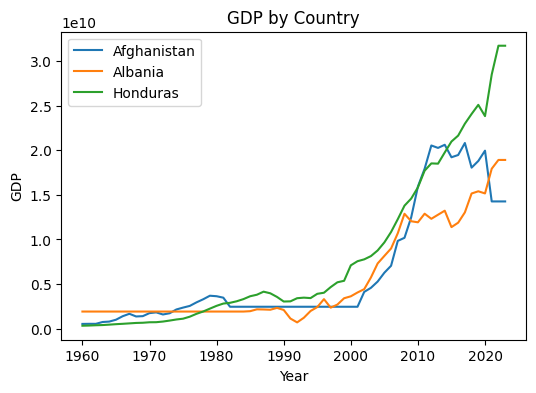

In [28]:
negara = ['Afghanistan', 'Albania', 'Honduras']
line_plot(gdp, 'GDP', negara)

In [29]:
dfs = [myst, gdp, elec, rural]

for label, df in zip(data_labels, dfs):
    print(f"{label}: {df.shape}")
    display(df.head())

Mystery Data: (16256, 4)


,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


GDP Data: (16256, 4)


,Country Name,Country Code,Year,GDP
0,Aruba,ABW,1960,1.330168e+09
1,Afghanistan,AFG,1960,5.377778e+08
2,Angola,AGO,1960,5.934074e+09
3,Albania,ALB,1960,1.924242e+09
4,Andorra,AND,1960,7.861921e+07


Electricity Data: (16256, 4)


,Country Name,Country Code,Year,Electricity Access Percent
0,Aruba,ABW,1960,0.0
1,Afghanistan,AFG,1960,0.0
2,Angola,AGO,1960,0.0
3,Albania,ALB,1960,0.0
4,Andorra,AND,1960,0.0


Rural Population Data: (16256, 4)


,Country Name,Country Code,Year,Rural Population Percent
0,Aruba,ABW,1960,49.224
1,Afghanistan,AFG,1960,91.779
2,Angola,AGO,1960,89.565
3,Albania,ALB,1960,69.295
4,Andorra,AND,1960,41.550


### 2.3 Process Population Data

In [30]:
# Preprocessing Population Dataframes
p1 = clean_columns(p1)

p2 = p2.rename(columns={'Country_Name': 'Country Name', 'Country_Code': 'Country Code', 'Indicator_Name': 'Indicator Name', 'Indicator_Code': 'Indicator Code'})
p2 = clean_columns(p2)

p3.columns = ['Country Name', 'Country Code', 'Year', 'Population']
p3.replace('', np.nan, inplace=True)
p3 = p3.astype({'Country Name': str, 'Country Code': str, 'Year': int, 'Population': float})
p3 = p3.pivot(index=['Country Name', 'Country Code'], columns='Year', values='Population').reset_index()
p3.columns.name = None

p4 = clean_columns(p4)

In [31]:
dfs = [p1, p2, p3, p4]

for df in dfs:
    print(df.shape)

(264, 60)
(264, 60)
(264, 60)
(264, 60)


In [32]:
#Update Dataframes
p1.update(p2[p2['Country Name'].isin(p1['Country Name'])])
p1.update(p3[p3['Country Name'].isin(p1['Country Name'])])
p1.update(p4[p4['Country Name'].isin(p1['Country Name'])])

In [33]:
# Merge Dataframes
merged_pop = pd.merge(p1, api_pop, on=['Country Name','Country Code'])
print('Duplicate values: ', merged_pop['Country Name'].duplicated().sum())
print("Population Data:", merged_pop.shape)
display(merged_pop.head())

Duplicate values:  1
Population Data: (255, 66)


,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,103795.0,104341.0,104822.0,105264.0,105962.0,106442.0,106585.0,106537.0,106445.0,NaN
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,32758020.0,33736494.0,34656032.0,35530081.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,NaN
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,26920466.0,27859305.0,28813463.0,29784193.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,NaN
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837849.0,2811666.0,2777689.0,NaN
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,79223.0,78014.0,77281.0,76965.0,75013.0,76343.0,77700.0,79034.0,79824.0,NaN


In [34]:
merged_pop[merged_pop.isna().any(axis=1)]

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,103795.0,104341.0,104822.0,105264.0,105962.0,106442.0,106585.0,106537.0,106445.0,NaN
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,32758020.0,33736494.0,34656032.0,35530081.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,NaN
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,26920466.0,27859305.0,28813463.0,29784193.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,NaN
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837849.0,2811666.0,2777689.0,NaN
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,79223.0,78014.0,77281.0,76965.0,75013.0,76343.0,77700.0,79034.0,79824.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,Kosovo,XKX,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,...,1821800.0,1801800.0,1816200.0,1830700.0,1797085.0,1788878.0,1790133.0,1786038.0,1761985.0,NaN
251,"Yemen, Rep.",YEM,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,5748588.0,5858638.0,...,26246327.0,26916207.0,27584213.0,28250420.0,30790513.0,31546691.0,32284046.0,32981641.0,33696614.0,NaN
252,South Africa,ZAF,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,20486439.0,21045785.0,...,54539571.0,55291225.0,56015473.0,56717156.0,57339635.0,58087055.0,58801927.0,59392255.0,59893885.0,NaN
253,Zambia,ZMB,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,3676189.0,3791887.0,...,15620974.0,16100587.0,16591390.0,17094130.0,17835893.0,18380477.0,18927715.0,19473125.0,20017675.0,NaN


In [35]:
# Fill missing values
merged_pop.drop_duplicates(subset=['Country Name'], inplace=True)
fill_missing_values(merged_pop)
pop = perform_melt(merged_pop, "Population")
pop = convert_year(pop)

In [36]:
merged_pop[merged_pop.isna().any(axis=1)]

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [37]:
pop

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
16251,Kosovo,XKX,2023,1761985.0
16252,"Yemen, Rep.",YEM,2023,33696614.0
16253,South Africa,ZAF,2023,59893885.0
16254,Zambia,ZMB,2023,20017675.0


### 2.4 Process Projects Data

In [38]:
# Drop Columns
kolom = ['id', 'regionname', 'countryname', 'envassesmentcategorycode', 'status', 'project_name', 'boardapprovaldate', 'closingdate', 'lendprojectcost', 'sector1']
proj = proj[kolom]

In [39]:
print("Total rows: ", proj.shape[0])
print("Duplicated values: ", proj.duplicated().sum())
print(proj.isna().sum() / proj.shape[0] * 100)

Total rows:  18248
Duplicated values:  0
id                           0.000000
regionname                   0.000000
countryname                  0.000000
envassesmentcategorycode    31.844586
status                       0.021920
project_name                 0.000000
boardapprovaldate            8.241999
closingdate                 18.352696
lendprojectcost              0.685007
sector1                      0.000000
dtype: float64


In [40]:
# Fill Missing Values
proj['countryname'] = proj['countryname'].str.split(';').str[0]
proj.fillna({'envassesmentcategorycode': '-'}, inplace=True)
proj['lendprojectcost'] = pd.to_numeric(proj['lendprojectcost'].str.replace(',', ''))
proj.fillna({'lendprojectcost':0}, inplace=True)
proj.fillna({'status': proj['status'].mode()[0]}, inplace=True)

In [41]:
# Fill Missing Values
proj['boardapprovaldate'] = pd.to_datetime(proj['boardapprovaldate'])
proj['boardapprovaldate'] = proj['boardapprovaldate'].bfill()

proj['closingdate'] = pd.to_datetime(proj['closingdate'])
proj['closingdate'] = proj['closingdate'].bfill()

In [42]:
# Replace And Regex
proj['sector1'] = proj['sector1'].replace('!$!0', 'Other')
proj['sector1'] = proj['sector1'].replace('!.+', '', regex=True)
proj['sector1'] = proj['sector1'].replace('^(\(Historic\))', '', regex=True)
proj['sector1'] = proj['sector1'].str.extract(r'^([^!$]+)')

In [43]:
print(proj.isnull().sum())

id                          0
regionname                  0
countryname                 0
envassesmentcategorycode    0
status                      0
project_name                0
boardapprovaldate           0
closingdate                 0
lendprojectcost             0
sector1                     0
dtype: int64


In [44]:
proj.head()

,id,regionname,countryname,envassesmentcategorycode,status,project_name,boardapprovaldate,closingdate,lendprojectcost,sector1
0,P162228,Other,World,C,Active,Creating a Trade in Value-Added Database for ...,2018-06-28 00:00:00+00:00,2023-12-31 00:00:00+00:00,500000.0,Other
1,P163962,Africa,Democratic Republic of the Congo,B,Active,Productive Inclusion Project,2018-06-28 00:00:00+00:00,2023-12-31 00:00:00+00:00,200000000.0,Other
2,P167672,South Asia,People's Republic of Bangladesh,-,Active,Additional Financing for Health Sector Support...,2018-06-28 00:00:00+00:00,2023-06-28 00:00:00+00:00,50000000.0,Other
3,P158768,South Asia,Islamic Republic of Afghanistan,A,Active,Public-Private Partnerships and Public Investm...,2018-06-27 00:00:00+00:00,2023-06-28 00:00:00+00:00,50000000.0,Other
4,P161364,Africa,Federal Republic of Nigeria,B,Active,Nigeria For Women Project,2018-06-27 00:00:00+00:00,2023-05-31 00:00:00+00:00,100000000.0,Social Protection


In [45]:
project_group = proj[['countryname', 'boardapprovaldate', 'lendprojectcost']]

## 3. Further Data Transformation

### 3.2 Check Outliers

#### a. Projects Data

In [46]:
# Check Outlier Projects_Data
fig = px.scatter(project_group, y="lendprojectcost", hover_name='countryname')
fig.show()

#### b. Population & GDP Data

In [47]:
gdp_myst = pd.merge(gdp, myst, on=['Country Name', 'Country Code', 'Year'])
gdp_myst.head()

,Country Name,Country Code,Year,GDP,Population
0,Aruba,ABW,1960,1.330168e+09,54211.0
1,Afghanistan,AFG,1960,5.377778e+08,8996351.0
2,Angola,AGO,1960,5.934074e+09,5643182.0
3,Albania,ALB,1960,1.924242e+09,1608800.0
4,Andorra,AND,1960,7.861921e+07,13411.0


In [48]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(gdp_myst['Population'].values.reshape(-1, 1), gdp_myst['GDP'].values.reshape(-1, 1))
inputs = np.linspace(1, 8e9, num=50).reshape(-1, 1)
predictions = model.predict(inputs)

fig = px.scatter(gdp_myst, x='Population', y='GDP', hover_name='Country Name')
fig.add_scatter(x=inputs.flatten(), y=predictions.flatten(), mode='lines', name='Linear Regression', line=dict(color='red', width=2))
fig.update_xaxes(title_text='Population')
fig.update_yaxes(title_text='GDP')

fig.show()


In [49]:
country_not_found = []

for country_code in gdp_myst['Country Code'].drop_duplicates().sort_values():
    try: 
        alpha_3 = countries.lookup(country_code).alpha_3
    except LookupError:
        country_not_found.append(country_code)

country_name = gdp_myst[['Country Name', 'Country Code']].drop_duplicates().sort_values('Country Name')

for country_code in country_not_found:
    country_name = gdp_myst.loc[gdp_myst['Country Code'] == country_code, 'Country Name'].iloc[0]
    print(f"{country_name}", end=", ")


Arab World, Central Europe and the Baltics, Channel Islands, Caribbean small states, East Asia & Pacific (excluding high income), Early-demographic dividend, East Asia & Pacific, Europe & Central Asia (excluding high income), Europe & Central Asia, Euro area, European Union, Fragile and conflict affected situations, Heavily indebted poor countries (HIPC), IBRD only, IDA & IBRD total, IDA total, IDA blend, IDA only, Latin America & Caribbean (excluding high income), Latin America & Caribbean, Least developed countries: UN classification, Low & middle income, Late-demographic dividend, Middle East & North Africa, Middle income, Middle East & North Africa (excluding high income), North America, OECD members, Other small states, Pre-demographic dividend, Pacific island small states, Post-demographic dividend, South Asia, Sub-Saharan Africa (excluding high income), Sub-Saharan Africa, Small states, East Asia & Pacific (IDA & IBRD countries), Europe & Central Asia (IDA & IBRD countries), Lat

In [50]:
clean_gdp_myst = gdp_myst[~gdp_myst['Country Code'].isin(country_not_found)]

In [51]:
model.fit(clean_gdp_myst['Population'].values.reshape(-1, 1), clean_gdp_myst['GDP'].values.reshape(-1, 1))

inputs = np.linspace(1, 8e9, num=50).reshape(-1, 1)
predictions = model.predict(inputs)

fig = px.scatter(clean_gdp_myst, x='Population', y='GDP', hover_name='Country Name')
fig.add_scatter(x=inputs.flatten(), y=predictions.flatten(), mode='lines', name='Linear Regression', line=dict(color='red', width=2))
fig.update_xaxes(title_text='Population')
fig.update_yaxes(title_text='GDP')

fig.show()

### 3.3 Dummy Variables

In [52]:
status = proj.copy()
print(status['status'].sort_values().unique())

['Active' 'Closed' 'Dropped' 'Pipeline']


In [53]:
dummies = pd.get_dummies(status['status'])
dummies.head()

,Active,Closed,Dropped,Pipeline
0,True,False,False,False
1,True,False,False,False
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False


In [54]:
status['year'] = status['boardapprovaldate'].dt.year
year = status[['year', 'lendprojectcost']]
years_project = pd.concat([year, dummies], axis=1)
years_project

,year,lendprojectcost,Active,Closed,Dropped,Pipeline
0,2018,500000.0,True,False,False,False
1,2018,200000000.0,True,False,False,False
2,2018,50000000.0,True,False,False,False
3,2018,50000000.0,True,False,False,False
4,2018,100000000.0,True,False,False,False
...,...,...,...,...,...,...
18243,1948,13500000.0,False,True,False,False
18244,1947,12000000.0,False,True,False,False
18245,1947,40000000.0,False,True,False,False
18246,1947,195000000.0,False,True,False,False


In [55]:
country_name = status[['countryname']]
country_project = pd.concat([country_name, dummies], axis=1)
country_project

,countryname,Active,Closed,Dropped,Pipeline
0,World,True,False,False,False
1,Democratic Republic of the Congo,True,False,False,False
2,People's Republic of Bangladesh,True,False,False,False
3,Islamic Republic of Afghanistan,True,False,False,False
4,Federal Republic of Nigeria,True,False,False,False
...,...,...,...,...,...
18243,Republic of Chile,False,True,False,False
18244,Grand Duchy of Luxembourg,False,True,False,False
18245,Kingdom of Denmark,False,True,False,False
18246,Kingdom of the Netherlands,False,True,False,False


### 3.4 Feature Engineering

In [56]:
project_group['boardapprovaldate'] = pd.to_datetime(project_group['boardapprovaldate']).dt.year
project_group = project_group[project_group['boardapprovaldate'] >= 1960].sort_values('boardapprovaldate')
df_project = project_group.groupby(['countryname', 'boardapprovaldate'])['lendprojectcost'].sum().reset_index()
print("total rows : ", df_project.shape[0])
df_project

total rows :  5069


,countryname,boardapprovaldate,lendprojectcost
0,Africa,1965,3.800000e+07
1,Africa,1967,1.300000e+07
2,Africa,1969,2.062970e+09
3,Africa,1970,5.280000e+07
4,Africa,1972,3.450000e+07
...,...,...,...
5064,World,2014,1.500000e+06
5065,World,2015,9.970000e+06
5066,World,2016,3.120000e+06
5067,World,2017,3.990000e+06


In [57]:
import country_converter as coco
cc = coco.CountryConverter()
match_these = pd.Series(df_project['countryname'].tolist())
short_name = cc.pandas_convert(series=match_these, to='name_short', not_found=None)
df_project['Short Name'] = short_name

Africa not found in regex
Andean Countries not found in regex
Aral Sea not found in regex
Asia not found in regex
Caribbean not found in regex
Caucasus not found in regex
Central Africa not found in regex
Central America not found in regex
Central Asia not found in regex
Democratic Socialist Republic of Sri Lan not found in regex
EU Accession Countries not found in regex
East Asia and Pacific not found in regex
Eastern Africa not found in regex
Europe and Central Asia not found in regex
Latin America not found in regex
Mekong not found in regex
Mercosur not found in regex
Middle East and North Africa not found in regex
Multi-Regional not found in regex
Organization of Eastern Caribbean States not found in regex
Pacific Islands not found in regex
Red Sea and Gulf of Aden not found in regex
Socialist Federal Republic of Yugoslavia not found in regex
South Asia not found in regex
Western Africa not found in regex
Western Balkans not found in regex
World not found in regex


In [58]:
df_project

,countryname,boardapprovaldate,lendprojectcost,Short Name
0,Africa,1965,3.800000e+07,Africa
1,Africa,1967,1.300000e+07,Africa
2,Africa,1969,2.062970e+09,Africa
3,Africa,1970,5.280000e+07,Africa
4,Africa,1972,3.450000e+07,Africa
...,...,...,...,...
5064,World,2014,1.500000e+06,World
5065,World,2015,9.970000e+06,World
5066,World,2016,3.120000e+06,World
5067,World,2017,3.990000e+06,World


In [59]:
proj_pop = df_project.merge(
    merged_pop,
    how='left',
    left_on='Short Name',
    right_on='Country Name'
)[[
    'Country Name', 'Country Code', 'boardapprovaldate', 'lendprojectcost'
]]
proj_pop.dropna(subset=['Country Name', 'Country Code'], inplace=True)
proj_pop.rename(columns={'boardapprovaldate':'year', 'lendprojectcost': 'projectcost'}, inplace=True)
proj_pop.reset_index(drop=True)

,Country Name,Country Code,year,projectcost
0,American Samoa,ASM,2010,200000.0
1,Antigua and Barbuda,ATG,2013,10000000.0
2,Argentina,ARG,1961,48500000.0
3,Argentina,ARG,1962,95000000.0
4,Argentina,ARG,1967,15300000.0
...,...,...,...,...
4276,World,WLD,2014,1500000.0
4277,World,WLD,2015,9970000.0
4278,World,WLD,2016,3120000.0
4279,World,WLD,2017,3990000.0


In [60]:
gdp_pop = gdp.merge(pop, on=['Country Name', 'Country Code', 'Year'])
gdp_pop['gdppercapita'] = gdp_pop['GDP'] / gdp_pop['Population']
rural_elec = rural.merge(elec, on=['Country Name', 'Country Code', 'Year'])
proj_pop.columns = ['countryname', 'countrycode','year', 'projectcost']
gdp_pop.columns = ['countryname', 'countrycode', 'year', 'gdp', 'population', 'gdppercapita']
rural_elec.columns = ['countryname', 'countrycode', 'year', 'ruralpopulationpercent', 'electricityaccesspercent']
print(gdp_pop.shape)
print(rural_elec.shape)

(16256, 6)
(16256, 5)


In [61]:
df_merge = gdp_pop.merge(rural_elec, on=['countryname', 'countrycode', 'year'])
df_country = df_merge.merge(proj_pop, on=['countryname', 'countrycode', 'year'], how='left')

In [62]:
df_country.fillna(0, inplace=True)
df_country.drop_duplicates(subset=['countryname', 'countrycode', 'year'], inplace=True)
df_country.reset_index(drop=True)

,countryname,countrycode,year,gdp,population,gdppercapita,ruralpopulationpercent,electricityaccesspercent,projectcost
0,Aruba,ABW,1960,1.330168e+09,54211.0,24536.857792,49.224,0.000000,0.0
1,Afghanistan,AFG,1960,5.377778e+08,8996351.0,59.777327,91.779,0.000000,0.0
2,Angola,AGO,1960,5.934074e+09,5643182.0,1051.547443,89.565,0.000000,0.0
3,Albania,ALB,1960,1.924242e+09,1608800.0,1196.073131,69.295,0.000000,0.0
4,Andorra,AND,1960,7.861921e+07,13411.0,5862.292602,41.550,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
16251,Kosovo,XKX,2023,9.409474e+09,1761985.0,5340.268798,0.000,100.000000,0.0
16252,"Yemen, Rep.",YEM,2023,2.160616e+10,33696614.0,641.196792,60.812,74.877197,0.0
16253,South Africa,ZAF,2023,4.052709e+11,59893885.0,6766.481254,31.665,89.300000,0.0
16254,Zambia,ZMB,2023,2.916378e+10,20017675.0,1456.901570,54.239,46.685116,0.0


### 3.5 Scaling Features

In [63]:
std_scaler = StandardScaler()
scaled_df = df_country.copy()

scaled_df['gdp_scaled'] = std_scaler.fit_transform(scaled_df[['gdp']])
scaled_df['population_scaled'] = std_scaler.fit_transform(scaled_df[['population']])
scaled_df['gdppercapita_scaled'] = std_scaler.fit_transform(scaled_df[['gdppercapita']])
scaled_df['ruralpopulation_scaled'] = std_scaler.fit_transform(scaled_df[['ruralpopulationpercent']])
scaled_df['electricityaccess_scaled'] = std_scaler.fit_transform(scaled_df[['electricityaccesspercent']])

clm = ['gdp_scaled', 'population_scaled', 'gdppercapita_scaled', 'ruralpopulation_scaled', 'electricityaccess_scaled']
scaled_df = scaled_df[clm]

In [64]:
scaled_df.head()

,gdp_scaled,population_scaled,gdppercapita_scaled,ruralpopulation_scaled,electricityaccess_scaled
0,-0.194049,-0.285379,0.777522,0.000640,-0.903662
1,-0.194218,-0.272689,-0.472935,1.679928,-0.903662
2,-0.193071,-0.277448,-0.422269,1.592560,-0.903662
3,-0.193923,-0.283173,-0.414886,0.792673,-0.903662
4,-0.194316,-0.285437,-0.176503,-0.302189,-0.903662


## 4. Data Load

#### 4.1 Save to CSV

In [65]:
df_country.to_csv('../data_final/world_data.csv', index=False)

#### 4.2 Load to Database

In [77]:
import psycopg2
from psycopg2 import sql

load_dotenv()

# Mengambil variabel lingkungan
host = os.getenv('PSG_HOST')
database = os.getenv('PSG_DATABASE')
user = os.getenv('PSG_USER')
password = os.getenv('PSG_PASSWORD')

# Koneksi ke database PostgreSQL
conn = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password
)

cur = conn.cursor()

create_table_query = """
CREATE TABLE IF NOT EXISTS country_data (
    countryname VARCHAR,
    countrycode VARCHAR,
    year INT,
    gdp NUMERIC(18,2),
    population BIGINT,
    gdppercapita NUMERIC(10,2),
    ruralpopulationpercent REAL,
    electricityaccesspercent REAL,
    projectcost NUMERIC(18,2)
);
"""
cur.execute(create_table_query)
conn.commit()


In [78]:
def insert_data_from_dataframe(df):
    for i, row in df.iterrows():
        insert_query = """
        INSERT INTO country_data (countryname, countrycode, year, gdp, population, gdppercapita, ruralpopulationpercent, electricityaccesspercent, projectcost)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
        """
        data = (row['countryname'], row['countrycode'], row['year'], row['gdp'], row['population'], row['gdppercapita'], row['ruralpopulationpercent'], row['electricityaccesspercent'], row['projectcost'])
        cur.execute(insert_query, data)
    conn.commit()

insert_data_from_dataframe(df_country)

cur.close()
conn.close()

## Data Visualization

In [ ]:
load_dotenv()
my_api = os.getenv("NAGA_AI_KEY")
client = OpenAI(
    api_key= my_api,
    base_url='https://api.naga.ac/v1'
    )

def generate(prompt, model="gpt-3.5-turbo", temperature=0, max_tokens=1000):
    response = client.chat.completions.create(
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )
    return response.choices[0].message.content

In [ ]:
df_country = pd.read_csv('../data_final/world_data.csv')
daftar_kolom = df_country.columns.tolist()
asean_countries = ["Indonesia", "Singapore", "Malaysia", "Thailand", "Vietnam", "Philippines", "Brunei Darussalam", "Cambodia", "Lao PDR", "Myanmar", "Timor-Leste"]
df_asean = df_country[df_country['countryname'].isin(asean_countries)]
df_2023 = df_country[df_country['year'] == 2023]
columns = ['countryname', 'countrycode','year', 'projectcost']
df_project = df_country[columns]

In [ ]:
prompt_1 = (
    f"saya memiliki dataset dengan kolom: {str(daftar_kolom)}. berikan analisis saya menarik untuk visualisasi yaitu analisis statistik, distribusi, korelasi dan tren"
)

In [ ]:
analisis = generate(prompt_1)
print(analisis)

### Analisis Statistik Deskriptif

#### Statistik Deskriptif

In [ ]:
print("\nStatistik Deskriptif tahun 2023:")
display(df_2023.describe())

#### Rata-Rata GDP Per Kapita

In [ ]:
avg_gdp_per_capita = df_asean.groupby('countryname')['gdppercapita'].mean().sort_values(ascending=False)
print("\nRata-rata GDP Per Kapita tiap Negara di ASEAN:")
print(avg_gdp_per_capita)

#### Rata-Rata Persentase Populasi Dengan Akses Listrik

In [ ]:
avg_electricity_access = df_asean.groupby('countryname')['electricityaccesspercent'].mean().sort_values(ascending=False)
print("\nPersentase Populasi dengan Akses Listrik tiap Negara di ASEAN:")
print(avg_electricity_access)

#### Rata-Rata Persentase Populasi Pedesaan

In [ ]:
avg_rural_population = df_asean.groupby('countryname')['ruralpopulationpercent'].mean().sort_values(ascending=False)
print("\nPersentase Populasi dengan Rural Population:")
print(avg_rural_population)

### Analisis Distribusi

#### hisplot distribusi data negara

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.histplot(data=df_2023, x='gdp', bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribusi GDP')
axes[0, 0].set_xlabel('GDP')
axes[0, 0].set_ylabel('Jumlah Negara')

sns.histplot(data=df_2023, x='population', bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribusi Populasi')
axes[0, 1].set_xlabel('Populasi')
axes[0, 1].set_ylabel('Jumlah Negara')

sns.histplot(data=df_2023, x='gdppercapita', bins=20, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribusi GDP per Kapita')
axes[0, 2].set_xlabel('GDP per Kapita')
axes[0, 2].set_ylabel('Jumlah Negara')

sns.histplot(data=df_2023, x='ruralpopulationpercent', bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribusi Persentase Penduduk Pedesaan')
axes[1, 0].set_xlabel('Persentase Penduduk Pedesaan')
axes[1, 0].set_ylabel('Jumlah Negara')

sns.histplot(data=df_2023, x='electricityaccesspercent', bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribusi Persentase Penduduk dengan Akses Listrik')
axes[1, 1].set_xlabel('Persentase Penduduk dengan Akses Listrik')
axes[1, 1].set_ylabel('Jumlah Negara')

fig.delaxes(axes[1, 2])
fig.suptitle('Distribusi Data Negara di Tahun 2023', fontsize=20)
plt.tight_layout()
plt.show()



#### uji normalitas 

In [ ]:
indo = df_country[df_country['countryname'] == 'Indonesia']
indo.reset_index(drop=True, inplace=True)

In [ ]:
indo

In [ ]:
from scipy import stats

def normality_test(data, column):
    column_data = data[column]
    stat, p_value = stats.shapiro(column_data)

    # Menafsirkan hasil uji
    alpha = 0.05
    if p_value > alpha:
        result = "Data kolom '{}' terdistribusi normal (tidak bisa menolak H0)".format(column)
    else:
        result = "Data kolom '{}' tidak terdistribusi normal (menolak H0)".format(column)

    return result

print(normality_test(indo, 'gdp'))
print(normality_test(indo, 'population'))
print(normality_test(indo, 'gdppercapita'))
print(normality_test(indo, 'ruralpopulationpercent'))
print(normality_test(indo, 'electricityaccesspercent'))

### Analisis Korelasi

#### Heatmap korelasi

In [ ]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(scaled_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Korelasi')
plt.show()

#### Scatter plot GDP dan Populasi

In [ ]:

fig = px.scatter(scaled_df, y='gdp_scaled', x='population_scaled', trendline='ols', trendline_color_override='red', title='Korelasi antara GDP dan Populasi')
fig.update_layout(title_x=0.5)
fig.show()

#### Scatter plot GDP dan Populasi

In [ ]:

fig2 = px.scatter(scaled_df, y='ruralpopulation_scaled', x='electricityaccess_scaled', trendline='ols', trendline_color_override='red', title='Korelasi antara Persentase Penduduk Pedesaan dan Akses Listrik')
fig2.show()

### Analisis Time Series

#### Plot Tren GDP

In [ ]:

fig = px.line(df_asean, x='year', y='gdp', color='countryname', title='Tren GDP Negara ASEAN',
              labels={'gdp': 'GDP (USD)', 'year': 'Tahun', 'countryname': 'Negara'})
fig.update_layout(title_x=0.5)
fig.show()

#### Plot Tren Populasi

In [ ]:
fig = px.line(df_asean, x='year', y='population', color='countryname', title='Tren Populasi Negara ASEAN',
              labels={'population': 'Populasi', 'year': 'Tahun', 'countryname': 'Negara'})
fig.update_layout(title_x=0.5)
fig.show()

#### Plot Tren GDP Per Kapita

In [ ]:

fig = px.line(df_asean, x='year', y='gdppercapita', color='countryname', title='Tren GDP Per Kapita Negara ASEAN',
              labels={'gdppercapita': 'GDP Per Kapita (USD)', 'year': 'Tahun', 'countryname': 'Negara'})
fig.update_layout(title_x=0.5)
fig.show()

#### Plot Tren Persentase Populasi Dengan Akses Listrik

In [ ]:

fig = px.line(df_asean, x='year', y='electricityaccesspercent', color='countryname', title='Tren Persentase Populasi dengan Akses Listrik Negara ASEAN',
              labels={'electricityaccesspercent': 'Persentase Akses Listrik', 'year': 'Tahun', 'countryname': 'Negara'})
fig.show()

#### Plot Tren Persentase Populasi Pedesaan

In [ ]:

fig = px.line(df_asean, x='year', y='ruralpopulationpercent', color='countryname', title='Tren Persentase Populasi Pedesaan Negara ASEAN',
              labels={'ruralpopulationpercent': 'Persentase Populasi Pedesaan', 'year': 'Tahun', 'countryname': 'Negara'})
fig.show()

#### Plot Tren projectcost

In [ ]:
import plotly.graph_objs as go
df_grouped = df_project.groupby('year')['projectcost'].sum().reset_index()

# Membuat plot menggunakan Plotly
plot_data = go.Bar(x=df_grouped['year'], y=df_grouped['projectcost'])

layout = go.Layout(
    title='Total Project Cost per Year',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total Project Cost')
)

fig = go.Figure(data=[plot_data], layout=layout)

# Menampilkan plot
fig.show()